## III. Feature selection, algorithm improvement

In this notebook, I shall run improve the best model from the preivous notebook (Random Forest Classificator) by undertaking the following steps:
    - Feature selection (hybrid recursive feature addition)
    - Tune hyper paramters

Then I shall check and prove the improvement.

Finally, I shall the Confusion Metrics and ROC Curve graph

### 1 Importing libraries

In [1]:
# import libraries
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score



%matplotlib inline
%matplotlib inline

### 2. Import datasets 

In [2]:
# Merge the two datasets
df=pd.read_csv('dfprepared.csv')
df.shape

(30541, 79)

### 3. Model creation & data balancing 

#### 3.1 Model Creation

In [3]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['Income'], axis=1),
    df['Income'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape


((21378, 78), (9163, 78))

#### 3.2 Smote for data imbalance

In [4]:
train_input = X_train
train_output = y_train


In [5]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(train_output)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(train_input, train_output)
print('New dataset shape {}'.format(Counter(train_output_new)))

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Original dataset shape Counter({0: 16617, 1: 4761})
New dataset shape Counter({0: 16617, 1: 16617})


Now both outcomes of the label are balanced

### 4. Feature selection (hybrid method: recursive addition)

In [6]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = RandomForestClassifier()

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features RFC ROC AUC=%f' % (auc_score_all))


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test all features RFC ROC AUC=0.844321


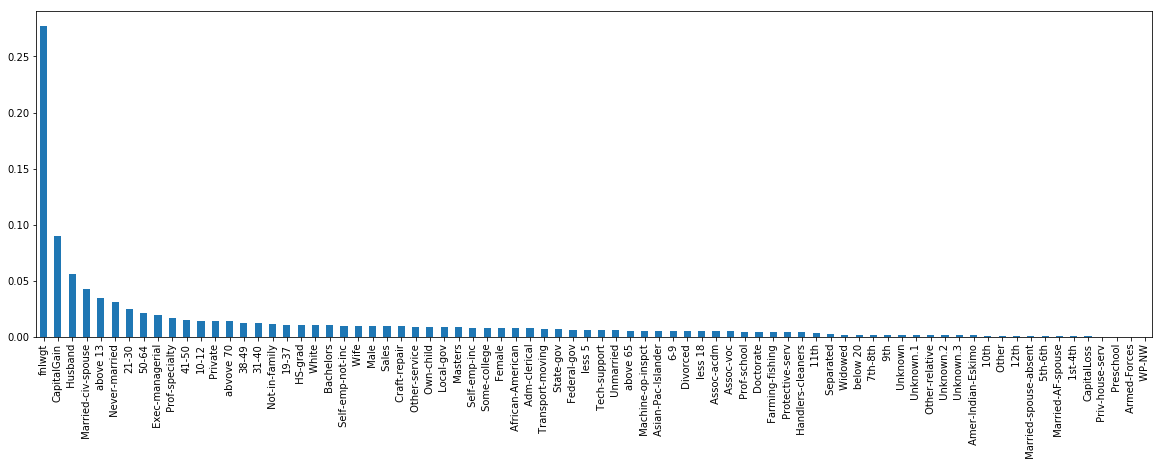

In [7]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [8]:
# view the list of ordered features
features = list(features.index)
features

['fnlwgt',
 'CapitalGain',
 ' Husband',
 ' Married-civ-spouse',
 'above 13',
 ' Never-married',
 '21-30',
 '50-64',
 ' Exec-managerial',
 ' Prof-specialty',
 '41-50',
 '10-12',
 ' Private',
 'abvove 70',
 '38-49',
 '31-40',
 ' Not-in-family',
 '19-37',
 ' HS-grad',
 ' White',
 ' Bachelors',
 ' Self-emp-not-inc',
 ' Wife',
 ' Male',
 ' Sales',
 ' Craft-repair',
 ' Other-service',
 ' Own-child',
 ' Local-gov',
 ' Masters',
 ' Self-emp-inc',
 ' Some-college',
 ' Female',
 ' African-American',
 ' Adm-clerical',
 ' Transport-moving',
 ' State-gov',
 ' Federal-gov',
 'less 5',
 ' Tech-support',
 ' Unmarried',
 'above 65',
 ' Machine-op-inspct',
 ' Asian-Pac-Islander',
 '6-9',
 ' Divorced',
 'less 18',
 ' Assoc-acdm',
 ' Assoc-voc',
 ' Prof-school',
 ' Doctorate',
 ' Farming-fishing',
 ' Protective-serv',
 ' Handlers-cleaners',
 ' 11th',
 ' Separated',
 ' Widowed',
 'below 20',
 ' 7th-8th',
 ' 9th',
 ' Unknown',
 ' Unknown.1',
 ' Other-relative',
 ' Unknown.2',
 ' Unknown.3',
 ' Amer-Indian-E

In [9]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_one_feature = RandomForestClassifier()

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]
auc_score_first = roc_auc_score(y_test, y_pred_test)
print('Test one feature RFC ROC AUC=%f' % (auc_score_first))

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test one feature RFC ROC AUC=0.560650


In [10]:
# the final step consists in adding one at a time
# all the features, from the most to the least
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in roc-auc
# if the increase is above this threshold,
# the feature will be kept
tol = 0.001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = RandomForestClassifier()

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with one feature
    print('All features Test ROC AUC={}'.format((auc_score_first)))

    # determine the increase in the roc-auc
    diff_auc = auc_score_int - auc_score_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        auc_score_first = auc_score_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  CapitalGain  which is feature  1  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.6568757660042344
All features Test ROC AUC=0.5606504247037195
Increase in ROC AUC=0.09622534130051486
keep:  CapitalGain

testing feature:   Husband  which is feature  2  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7440725928662606
All features Test ROC AUC=0.6568757660042344
Increase in ROC AUC=0.08719682686202623
keep:   Husband

testing feature:   Married-civ-spouse  which is feature  3  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7636156215640424
All features Test ROC AUC=0.7440725928662606
Increase in ROC AUC=0.019543028697781795
keep:   Married-civ-spouse

testing feature:  above 13  which is feature  4  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7821971006324926
All features Test ROC AUC=0.7636156215640424
Increase in ROC AUC=0.018581479068450202
keep:  above 13

testing feature:   Never-married  which is feature  5  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7852552411834847
All features Test ROC AUC=0.7821971006324926
Increase in ROC AUC=0.0030581405509920723
keep:   Never-married

testing feature:  21-30  which is feature  6  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7831679142119503
All features Test ROC AUC=0.7852552411834847
Increase in ROC AUC=-0.0020873269715343534
remove:  21-30

testing feature:  50-64  which is feature  7  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7803894205136488
All features Test ROC AUC=0.7852552411834847
Increase in ROC AUC=-0.004865820669835874
remove:  50-64

testing feature:   Exec-managerial  which is feature  8  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7905437468613182
All features Test ROC AUC=0.7852552411834847
Increase in ROC AUC=0.005288505677833566
keep:   Exec-managerial

testing feature:   Prof-specialty  which is feature  9  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7883535485630091
All features Test ROC AUC=0.7905437468613182
Increase in ROC AUC=-0.0021901982983091317
remove:   Prof-specialty

testing feature:  41-50  which is feature  10  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7880001357790898
All features Test ROC AUC=0.7905437468613182
Increase in ROC AUC=-0.0025436110822284475
remove:  41-50

testing feature:  10-12  which is feature  11  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7921869918654221
All features Test ROC AUC=0.7905437468613182
Increase in ROC AUC=0.0016432450041038438
keep:  10-12

testing feature:   Private  which is feature  12  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.789048344822475
All features Test ROC AUC=0.7921869918654221
Increase in ROC AUC=-0.0031386470429470847
remove:   Private

testing feature:  abvove 70  which is feature  13  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.792340814917891
All features Test ROC AUC=0.7921869918654221
Increase in ROC AUC=0.00015382305246891548
remove:  abvove 70

testing feature:  38-49  which is feature  14  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7954698869079092
All features Test ROC AUC=0.7921869918654221
Increase in ROC AUC=0.003282895042487133
keep:  38-49

testing feature:  31-40  which is feature  15  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7994601260229061
All features Test ROC AUC=0.7954698869079092
Increase in ROC AUC=0.003990239114996852
keep:  31-40

testing feature:   Not-in-family  which is feature  16  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.7995206873685072
All features Test ROC AUC=0.7994601260229061
Increase in ROC AUC=6.056134560117332e-05
remove:   Not-in-family

testing feature:  19-37  which is feature  17  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8009927221301666
All features Test ROC AUC=0.7994601260229061
Increase in ROC AUC=0.001532596107260531
keep:  19-37

testing feature:   HS-grad  which is feature  18  out of  78
New Test ROC AUC=0.7996873347698448
All features Test ROC AUC=0.8009927221301666
Increase in ROC AUC=-0.0013053873603218191
remove:   HS-grad

testing feature:   White  which is feature  19  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8068898140241272
All features Test ROC AUC=0.8009927221301666
Increase in ROC AUC=0.005897091893960593
keep:   White

testing feature:   Bachelors  which is feature  20  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8048410983671112
All features Test ROC AUC=0.8068898140241272
Increase in ROC AUC=-0.0020487156570160314
remove:   Bachelors

testing feature:   Self-emp-not-inc  which is feature  21  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.809534153280489
All features Test ROC AUC=0.8068898140241272
Increase in ROC AUC=0.0026443392563618717
keep:   Self-emp-not-inc

testing feature:   Wife  which is feature  22  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8073145039168534
All features Test ROC AUC=0.809534153280489
Increase in ROC AUC=-0.002219649363635612
remove:   Wife

testing feature:   Male  which is feature  23  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8051266907400321
All features Test ROC AUC=0.809534153280489
Increase in ROC AUC=-0.004407462540456986
remove:   Male

testing feature:   Sales  which is feature  24  out of  78
New Test ROC AUC=0.8051139355251195
All features Test ROC AUC=0.809534153280489
Increase in ROC AUC=-0.004420217755369604
remove:   Sales

testing feature:   Craft-repair  which is feature  25  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8049247158870938
All features Test ROC AUC=0.809534153280489
Increase in ROC AUC=-0.004609437393395255
remove:   Craft-repair

testing feature:   Other-service  which is feature  26  out of  78
New Test ROC AUC=0.8115809331867323
All features Test ROC AUC=0.809534153280489
Increase in ROC AUC=0.0020467799062432457
keep:   Other-service

testing feature:   Own-child  which is feature  27  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8088952518245834
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0026856813621488618
remove:   Own-child

testing feature:   Local-gov  which is feature  28  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8095498466885387
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0020310864981936128
remove:   Local-gov

testing feature:   Masters  which is feature  29  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8124504655204071
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=0.0008695323336748162
remove:   Masters

testing feature:   Self-emp-inc  which is feature  30  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8064890099132562
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.005091923273476073
remove:   Self-emp-inc

testing feature:   Some-college  which is feature  31  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8091571312505391
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0024238019361931817
remove:   Some-college

testing feature:   Female  which is feature  32  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.810425428243378
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0011555049433542575
remove:   Female

testing feature:   African-American  which is feature  33  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8060562659146366
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0055246672720956624
remove:   African-American

testing feature:   Adm-clerical  which is feature  34  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8086883684607573
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0028925647259749887
remove:   Adm-clerical

testing feature:   Transport-moving  which is feature  35  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8099307056530559
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.001650227533676385
remove:   Transport-moving

testing feature:   State-gov  which is feature  36  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8093415115116334
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0022394216750989404
remove:   State-gov

testing feature:   Federal-gov  which is feature  37  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8054644101159016
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0061165230708306595
remove:   Federal-gov

testing feature:  less 5  which is feature  38  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8084084105052641
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0031725226814681706
remove:  less 5

testing feature:   Tech-support  which is feature  39  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8068470201052605
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.004733913081471752
remove:   Tech-support

testing feature:   Unmarried  which is feature  40  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8073776577858108
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.004203275400921469
remove:   Unmarried

testing feature:  above 65  which is feature  41  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8065788494892936
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.005002083697438708
remove:  above 65

testing feature:   Machine-op-inspct  which is feature  42  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8096379579156721
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.0019429752710602433
remove:   Machine-op-inspct

testing feature:   Asian-Pac-Islander  which is feature  43  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8061019634596622
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.005478969727070071
remove:   Asian-Pac-Islander

testing feature:  6-9  which is feature  44  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8050918472261245
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=-0.006489085960607821
remove:  6-9

testing feature:   Divorced  which is feature  45  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8129412129082496
All features Test ROC AUC=0.8115809331867323
Increase in ROC AUC=0.0013602797215173101
keep:   Divorced

testing feature:  less 18  which is feature  46  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8122597940693019
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0006814188389476783
remove:  less 18

testing feature:   Assoc-acdm  which is feature  47  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8132535946891847
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=0.0003123817809350671
remove:   Assoc-acdm

testing feature:   Assoc-voc  which is feature  48  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8070545256746922
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.005886687233557453
remove:   Assoc-voc

testing feature:   Prof-school  which is feature  49  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8123347698447638
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0006064430634857843
remove:   Prof-school

testing feature:   Doctorate  which is feature  50  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8112496432687861
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.001691569639463486
remove:   Doctorate

testing feature:   Farming-fishing  which is feature  51  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8076779065574387
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.005263306350810959
remove:   Farming-fishing

testing feature:   Protective-serv  which is feature  52  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8090802888582611
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.003860924049988501
remove:   Protective-serv

testing feature:   Handlers-cleaners  which is feature  53  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8063185947113076
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.006622618196941987
remove:   Handlers-cleaners

testing feature:   11th  which is feature  54  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8100055085936273
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0029357043146223116
remove:   11th

testing feature:   Separated  which is feature  55  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.808079229172981
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.004861983735268582
remove:   Separated

testing feature:   Widowed  which is feature  56  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8121861318390073
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0007550810692422694
remove:   Widowed

testing feature:  below 20  which is feature  57  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8074643517668427
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.005476861141406886
remove:  below 20

testing feature:   7th-8th  which is feature  58  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8074645937356892
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.005476619172560371
remove:   7th-8th

testing feature:   9th  which is feature  59  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8073899636300084
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.005551249278241244
remove:   9th

testing feature:   Unknown  which is feature  60  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.813151138166147
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=0.00020992525789742533
remove:   Unknown

testing feature:   Unknown.1  which is feature  61  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8067814465478375
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0061597663604121555
remove:   Unknown.1

testing feature:   Other-relative  which is feature  62  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8097692087314527
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.003172004176796861
remove:   Other-relative

testing feature:   Unknown.2  which is feature  63  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8099676577526267
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.00297355515562292
remove:   Unknown.2

testing feature:   Unknown.3  which is feature  64  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8080382673039527
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.004902945604296938
remove:   Unknown.3

testing feature:   Amer-Indian-Eskimo  which is feature  65  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8091159965466206
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0038252163616290247
remove:   Amer-Indian-Eskimo

testing feature:   10th  which is feature  66  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8086343057070356
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.004306907201213961
remove:   10th

testing feature:   Other  which is feature  67  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8112209181099993
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0017202947982503103
remove:   Other

testing feature:   12th  which is feature  68  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8118591282263434
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0010820846819061813
remove:   12th

testing feature:   Married-spouse-absent  which is feature  69  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.811344737025492
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0015964758827575753
remove:   Married-spouse-absent

testing feature:   5th-6th  which is feature  70  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.809056541344318
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0038846715639315743
remove:   5th-6th

testing feature:   Married-AF-spouse  which is feature  71  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8108940181982696
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.002047194709980049
remove:   Married-AF-spouse

testing feature:   1st-4th  which is feature  72  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8049012449089754
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.0080399679992742
remove:   1st-4th

testing feature:  CapitalLoss  which is feature  73  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8077777705571201
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.005163442351129532
remove:  CapitalLoss

testing feature:   Priv-house-serv  which is feature  74  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8073413278918458
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.005599885016403849
remove:   Priv-house-serv

testing feature:   Preschool  which is feature  75  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8068631628840253
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.006078050024224346
remove:   Preschool

testing feature:   Armed-Forces  which is feature  76  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8081878040511392
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.004753408857110397
remove:   Armed-Forces

testing feature:   WP-NW  which is feature  77  out of  78


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


New Test ROC AUC=0.8070691475064211
All features Test ROC AUC=0.8129412129082496
Increase in ROC AUC=-0.005872065401828497
remove:   WP-NW
DONE!!
total features to keep:  15


In [11]:
# capture the 15 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_rfc = RandomForestClassifier()

# fit the model with the selected features
final_rfc.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_rfc.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))

Test selected features ROC AUC=0.808176


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


We've reduce feature space from 78 to 15, but we've lost a bit of ROC, we shall try to improve it by tunning its parameters. 

In [13]:
print('Test all features RFC ROC AUC=%f' % (auc_score_all))
print('Test selected features ROC AUC=%f' % (auc_score_final))
print('ROC AUC improvement',(auc_score_final-auc_score_all))

Test all features RFC ROC AUC=0.844321
Test selected features ROC AUC=0.808176
ROC AUC improvement -0.03614558283796543


### 5. Tune mode hyperparamters

In [15]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']


# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
from sklearn.ensemble import RandomForestClassifier
#making the instance
rfc=RandomForestClassifier()
# Random search of parameters
rfc_model = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_model.fit(X_train[features_to_keep], y_train)
# print results
print(rfc_model.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 40.6min finished


{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 460}


In [43]:
seed_val = 1000

np.random.seed(seed_val)

rfc2 = RandomForestClassifier(n_estimators=200, max_depth=460, max_features='sqrt')
rfc2.fit(X_train[features_to_keep],y_train)
rfc2_predict = rfc2.predict_proba(X_test[features_to_keep])[:, 1]

auc_score_final2 = roc_auc_score(y_test, rfc2_predict)
print('Test selected features ROC AUC=%f' % (auc_score_final2))





Test selected features ROC AUC=0.842979


**Check for improvement**

In [44]:
print ('Model ROC AUC improvement is',(auc_score_final2-auc_score_final))

Model ROC AUC improvement is 0.034803623614832135


If we compare original ROC AUC with the latest one, we find:


In [47]:
print('Test all features RFC ROC AUC=%f' % (auc_score_all))
print('Test selected features ROC AUC=%f' % (auc_score_final2))
print ('Model ROC AUC change is',(auc_score_final2-auc_score_all))



Test all features RFC ROC AUC=0.844321
Test selected features ROC AUC=0.842979
Model ROC AUC change is -0.0013419592231332933


The difference of -0.00134 is within the acceptable error, so we can conclude we have improved our model by reducing the featue space from 78 to 15 and kept the same ROC AUC

**7.Save the model**

In [48]:
from sklearn.externals import joblib
from joblib import dump, load
dump(rfc2,'rfc2.joblib')  

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['rfc2.joblib']

**7. Evidence that the model will generalize well**

In [49]:
import sklearn.metrics as sklm

labels = np.array(df['Income'])
probabilities = rfc2.predict_proba(X_test[features_to_keep])

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)

def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)  

                 Confusion matrix
                 Score positive    Score negative
Actual positive      6274               862
Actual negative       928              1099

Accuracy  0.80
 
           Positive      Negative
Num case     7136          2027
Precision    0.87          0.56
Recall       0.88          0.54
F1           0.88          0.55


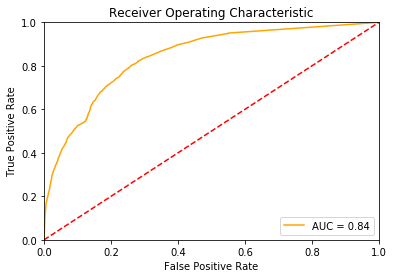

In [50]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)